In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
from env import github_token, github_username

import prepare
import acquire
#import explore
#import model
from acquire import scrape_github_data
from acquire import get_github_data
import unicodedata
import re
import json
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#musicbot_df = scrape_github_data()

In [3]:
#musicbot_df

In [4]:
#musicbot_df = pd.DataFrame(musicbot_df)
#musicbot_df

In [5]:
#df = pd.DataFrame(acquire.scrape_github_data())

In [6]:
#df.shape


In [7]:
#df.head()


In [8]:
#df.info()


In [9]:
#df.language.value_counts()


In [10]:
#df = df.dropna()

In [11]:
#df.info()


In [12]:
df = get_github_data()

In [13]:
# prepare the data by creating clean, stemmed and lemmatized columns
df = prepare.prep_github_data(df, column='readme_contents')


In [14]:
df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,jagrosh/MusicBot,Java,"<img align=""right"" src=""https://i.imgur.com/zr...",img alignright srchttpsiimgurcomzre80hypng hei...,img alignright srchttpsiimgurcomzre80hypng hei...,img alignright srchttpsiimgurcomzre80hypng hei...
1,Just-Some-Bots/MusicBot,Python,# MusicBot\n\n[![GitHub stars](https://img.shi...,musicbot github starshttpsimgshieldsiogithubst...,musicbot github starshttpsimgshieldsiogithubst...,musicbot github starshttpsimgshieldsiogithubst...
2,SudhanPlayz/Discord-MusicBot,JavaScript,"<h1 align=""center""><img src=""./assets/logo.gif...",h1 aligncenterimg srcassetslogogif width30px d...,h1 aligncenterimg srcassetslogogif width30px d...,h1 aligncenterimg srcassetslogogif width30px d...
3,IVETRI/SongPlayRoBot,Python,# Check Our New Bot Repo & Video :\n\n[Video](...,check new bot repo video videohttpsyoutube3pn0...,check new bot repo video videohttpsyoutube3pn0...,check new bot repo video videohttpsyoutube3pn0...
5,galnir/Master-Bot,TypeScript,# A Discord Music Bot written in TypeScript Sa...,discord music bot written typescript sapphire ...,discord music bot written typescript sapphir d...,discord music bot written typescript sapphire ...
...,...,...,...,...,...,...
192,Micium-Development/Bounce,JavaScript,### 📥 Micium-Development Is recruiting develop...,miciumdevelopment recruiting developers want j...,miciumdevelop recruit develop want join dev te...,miciumdevelopment recruiting developer want jo...
193,philliphqs/hqs.bot,Python,"<br />\n<p align=""center"">\n <a href=""https:/...",br p aligncenter hrefhttpsgithubcomphilliphqsh...,br p aligncent hrefhttpsgithubcomphilliphqshqs...,br p aligncenter hrefhttpsgithubcomphilliphqsh...
196,MrRizoel/RiZoeLXMusic,Python,"<h2 align=""centre"">ℝ𝚒ℤ𝚘𝚎𝕃𝕏𝕄𝚞𝚜𝚒𝚌 🎵</h2>\n\n### ...",h2 aligncentrerizoelxmusic h2 bot play music t...,h2 aligncentrerizoelxmus h2 bot play music tel...,h2 aligncentrerizoelxmusic h2 bot play music t...
197,noirscape/MusicBot-2,Python,# Dynamic cog bot template\n\nThis is a bot te...,dynamic cog bot template bot template discordp...,dynam cog bot templat bot templat discordpi fr...,dynamic cog bot template bot template discordp...


## Exploration

# Explore and visualize the natural language data that you have acquired. Here are some ideas for exploration:

> - What are the most common words in READMEs?
> - Does the length of the README vary by programming language?
> - Do different programming languages use a different number of unique words?
> - Are there any words that uniquely identify a programming language?


In [15]:
train, test = prepare.split_github_data(df)

train---> (128, 6)
test---> (32, 6)


In [16]:
# counts most frequent words from sentences in a df

top_20_words_readme = Counter(" ".join(train["lemmatized"]).split()).most_common(20)
top_20_words_readme


[('bot', 416),
 ('music', 291),
 ('song', 216),
 ('musicbot', 184),
 ('command', 175),
 ('play', 175),
 ('discord', 161),
 ('text', 157),
 ('option', 152),
 ('spotify', 133),
 ('youtube', 132),
 ('help', 129),
 ('file', 129),
 ('default', 108),
 ('support', 106),
 ('run', 105),
 ('token', 100),
 ('install', 100),
 ('queue', 95),
 ('playlist', 90)]

In [17]:
js_words = ' '.join(train[train.language=='JavaScript'].lemmatized)
python_words = ' '.join(train[train.language=='Python'].lemmatized)
j_words = ' '.join(train[train.language=='Java'].lemmatized)
ts_words = ' '.join(train[train.language=='TypeScript'].lemmatized)
go_words = ' '.join(train[train.language=='Go'].lemmatized)
kotlin_words = ' '.join(train[train.language=='Kotlin'].lemmatized)

js_words = re.sub(r'\s.\s', '', js_words)
python_words = re.sub(r'\s.\s', '', python_words)
j_words = re.sub(r'\s.\s', '', j_words)
ts_words = re.sub(r'\s.\s', '', ts_words)
go_words = re.sub(r'\s.\s', '', go_words)
kotlin_words = re.sub(r'\s.\s', '', kotlin_words)



In [18]:
js_words

'discordjs v13 slash command music bot h3discord httpsdiscordggfy4wmsthrzh3 h3youtube httpsbitly3zgizyrh3 hr h3 discord developer httpsdiscorddevbr discord permission httpsbitly3l4rzpibr download visual studio code httpscodevisualstudiocomdownloadbr download nodejs v16 httpsnodejsorgbr mongodb httpsmongodbcom h3 discordmusicbottemplate playteddypicker1jhttpswwwarknightskr httpsbluearchivenexoncomhome discordjshttpsdiscordjsorg youtubedlhttpsyoutubedlorg youtubedl rhythm hydra chip discordjs voice builder rest opushttpsgithubcomdiscordjsdiscordjs ffmpeghttpsgithubcomffmpegffmpeg nodeytdlcorehttpsgithubcomfentnodeytdlcore nodeytsrhttpsgithubcomtimeforaninjanodeytsr nodeytplhttpsgithubcomtimeforaninjanodeytpl playdlhttpsgithubcomplaydlplaydl scdlhttpsgithubcomzackradisicnodesoundclouddownloader snowsanthttpsmediadiscordappnetattachments91701405261248103495771418787279678220220328_035332png 100 100 arishttpsmediadiscordappnetattachments91701405261248103495771418808669393820220328_035345png

In [19]:
# returns the frequency of top words by each language

js_freq = pd.Series(js_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
j_freq = pd.Series(j_words.split()).value_counts()
ts_freq = pd.Series(ts_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
kotlin_freq = pd.Series(kotlin_words.split()).value_counts()

js_freq.head()

bot        165
music       69
discord     68
song        60
command     57
dtype: int64

In [20]:
word_counts = (pd.concat([js_freq, python_freq, j_freq, ts_freq, go_freq, kotlin_freq], axis=1, sort=True)
               .set_axis(['JavaScript', 'Python', 'Java', 'TypeScript', 'Go', 'Kotlin'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts['all'] = word_counts['JavaScript'] + word_counts['Python'] + word_counts['Java'] + word_counts['TypeScript'] + word_counts['Go'] + word_counts['Kotlin']
word_counts.sort_values(by="all", ascending = False).head(20)

,JavaScript,Python,Java,TypeScript,Go,Kotlin,all
bot,165,126,48,34,10,23,406
music,69,176,16,15,6,5,287
song,60,115,7,10,8,12,212
musicbot,17,137,5,6,10,5,180
command,57,59,13,19,11,11,170
play,48,84,3,7,19,9,170
discord,68,35,25,20,5,2,155
text,7,139,5,1,1,1,154
option,5,132,0,0,3,1,141
spotify,4,101,1,3,6,17,132


Text(0.5, 1.0, 'Proportion of Languages for the 20 most common words in our text sample')

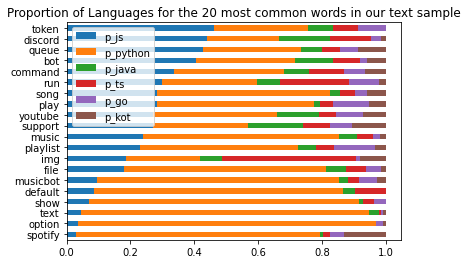

In [21]:
# visualize the percentage of the terms

(word_counts.assign(p_js = word_counts.JavaScript/word_counts['all'], 
                   p_python = word_counts.Python/word_counts['all'],
                    p_java = word_counts.Java/word_counts['all'],
                    p_ts = word_counts.TypeScript/word_counts['all'],
                    p_go = word_counts.Go/word_counts['all'],
                    p_kot = word_counts.Kotlin/word_counts['all'])
 .sort_values(by='all')[['p_js', 'p_python', 'p_java', 'p_ts', 'p_go', 'p_kot']]
 .tail(20)
 .sort_values('p_js')
 .plot.barh(stacked=True)
)

plt.title("Proportion of Languages for the 20 most common words in our text sample")